

# Data Loading



In [ ]:
from more_itertools import unzip
from torch.utils.data import DataLoader, Dataset, random_split
import kaggle
import zipfile
import pandas as pd
import os
from PIL import Image
from yaml import load
from torchvision import transforms
import pandas as pd
import numpy as np
import torch


class HistopathologicCancerDetectionDataset(Dataset):
    KAGGLE_DATASET = "histopathologic-cancer-detection"

    def __init__(self, data_path,figsize=224):
        self.data_path = data_path
        self._download()
        self.train_labels = pd.read_csv(
            os.path.join(self.data_path, "train_labels.csv")
        )
        self.transforms = transforms.Compose([transforms.Resize(figsize),
                                              transforms.ToTensor()],
                                             )

    def __len__(self):
        return len(self.train_labels)

    def __getitem__(self, index):
        image_id = self.train_labels["id"].iloc[index]
        label = self.train_labels["label"].iloc[index]
        img = Image.open(os.path.join(self.data_path, "train", image_id + ".tif"))
        return self.transforms(img), label

    def _download(self):
        kaggle.api.authenticate()
        kaggle.api.competition_download_files(
            self.KAGGLE_DATASET, path=self.data_path, quiet=False
        )
        # Only unzip if we cannot find certain files
        if not set(["train", "train_labels.csv"]).issubset(os.listdir(self.data_path)):
            with zipfile.ZipFile(
                os.path.join(self.data_path, self.KAGGLE_DATASET + ".zip")
            ) as zipped:
                zipped.extractall(self.data_path)


def load_data(data_path=None,figsize=224 ,test_split=0.33, batch_size=32):
    """
    Downloads the dataset from Kaggle if needed, creates a Pytorch Dataset and then
    setups data loaders for the training and test set.

    Required setup:
    1. Go to https://www.kaggle.com/<ACCOUNT_NAME>/account
    2. Click "Create New API Token"
    3. Add Token file to ~/.kaggle/kaggle.json
    """
    if not data_path:
        data_path = os.path.join(os.path.dirname(os.path.realpath(__file__)), "data")
    dataset = HistopathologicCancerDetectionDataset(data_path,figsize)
    test_size = int(len(dataset) * test_split)
    train_size = len(dataset) - test_size
    train_set, test_set = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

Train Model Code

In [ ]:
def train_model(model, criterion, optimizer, scheduler,train_loader,val_loader, num_epochs=25):
    '''
    Function to train the model 
    '''
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader=train_loader# Set model to training mode and choose the correct dataloader
            else:
                model.eval() 
                loader=val_loader# Set model to evaluate mode and choose the correct dataloader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for s in loader:
                #To(device) transfers the image is on the GPU
                inputs = s[0].to(device)#zeros element here refers to image
                
                #casting labels to long as float doesn't work to train the resnet
                
                labels = (s[1]).type(torch.LongTensor)# first element is the label
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(loader)
            if(phase== 'train'):
                cf_matrix=evaluate_model(model,train_loader)
                tn, fp, fn, tp = cf_matrix.ravel()
                specificity=tn/(tn+fp)
                sensitivity=tp/(tp+fn)
                precision=tp/(tp+fp)
                epoch_acc=(tp + tn) / (tp + fn + fp + tn)
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                print('train Sensitivity is {}'.format(sensitivity))
                print()
                print('train specificity is {}'.format(specificity))
                print()
                print('train precision is {}'.format(precision))
                print()
                print('Confusion matrix {}'.format(cf_matrix))
                metrics={"train_loss": epoch_loss, 
                         "train_accuracy":epoch_acc,
                        "train_Sensitivity ": sensitivity,
                        "train_precision ":precision,
                        "train_specificity ":(specificity),
                         
                        }
                
                
            else:
                cf_matrix=evaluate_model(model,val_loader)
                tn, fp, fn, tp = cf_matrix.ravel()
                specificity=tn/(tn+fp)
                sensitivity=tp/(tp+fn)
                precision=tp/(tp+fp)
                epoch_acc=(tp + tn) / (tp + fn + fp + tn)
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                print('val Sensitivity is {}'.format(sensitivity))
                print()
                print('val specificity is {}'.format(specificity))
                print()
                print(' val precision is {}'.format(precision))
                print()

                print()
                print('Confusion matrix {}'.format(cf_matrix))
                metrics={"val_loss": epoch_loss, 
                         "val_accuracy":epoch_acc,
                        "val_Sensitivity ": sensitivity,
                        "val_precision ":precision,
                        "val_specificity ":(specificity),
                         
                        }
                
            #wandb.log({**metrics})
            #Calculate classification metrics

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model,test_loader,num_images=6):
    '''
    Function to visualize the output of the model
    '''
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, s in enumerate(test_loader):
            inputs = s[0].to(device)
            #concat the input to change to 3 channels
            #casting labels to long as float doesn't work to train the resnet
            labels = (s[1]).type(torch.LongTensor)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
           

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {preds[j]} True label: {labels[j]}')
                #spliting x to visualize output to undo concat
                x=torch.split(inputs.cpu().data[j],3, dim=0)[0][0]
                plt.imshow(x)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def evaluate_model(model,val_loader):
    '''
    Method to check the model preformance per different classification metrics
    '''
    was_training = model.training
    model.eval()
    y_pred = []
    y_true = []
    CM=0
    with torch.no_grad():
        for i, s in enumerate(val_loader):
            inputs = s[0].to(device)
            
            #casting labels to long as float doesn't work to train the resnet
            labels = (s[1]).type(torch.LongTensor)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.data.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())
    cf_matrix = confusion_matrix(y_true, y_pred)   
    
    return cf_matrix




> Creating Dataset and initliasing GPU





In [ ]:
#Code checks for gpu and if so sets device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#Check that gpu is avaiable should print True
torch.cuda.is_available()

True

In [ ]:
#Creates dataset instance,train and test loaders
train=HistopathologicCancerDetectionDataset(data_path='.')
train_loader, test_loader=load_data(data_path='.',figsize=224,batch_size=32)

100%|██████████| 6.31G/6.31G [00:56<00:00, 120MB/s]



histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


Visualisation of one image to make sure data is loaded correctly 

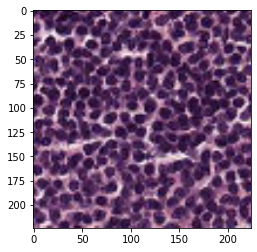

In [ ]:
import matplotlib.pyplot as plt
s=(next(iter(train_loader))[0])#First element in dataloader is the image
plt.imshow(s[0, :,:,:].permute(1, 2, 0)); #data loader returns 4d tensor with incorrect order of RGB 

# Model and training 

### Resnet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix

cudnn.benchmark = True
model_resnet = models.resnet18(pretrained=True)#choosing the model
num_ftrs = model_resnet.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_resnet.fc = nn.Linear(num_ftrs, 2)

model_resnet = model_resnet.to(device)#To train on GPU
criterion = nn.CrossEntropyLoss()#Defined cross entropy loss

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)#choose which parameters to optimize and hyperparameters

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
#Actual resnet model training
model_resnet = train_model(model_resnet, criterion, optimizer_ft, exp_lr_scheduler,train_loader, test_loader,num_epochs=5)

Epoch 0/4
----------
train Loss: 6.2874 Acc: 0.9627
train Sensitivity is 0.9310477787091366

train specificity is 0.9842879442159354

train precision is 0.975771312109073

Confusion matrix [[86388  1379]
 [ 4113 55537]]
val Loss: 4.1810 Acc: 0.9536
val Sensitivity is 0.917195506838158

val specificity is 0.9784196008437449

 val precision is 0.9667000500751126


Confusion matrix [[42210   931]
 [ 2440 27027]]

Epoch 1/4
----------
train Loss: 3.7644 Acc: 0.9763
train Sensitivity is 0.9754903604358759

train specificity is 0.9768022149555072

train precision is 0.966192879914984

Confusion matrix [[85731  2036]
 [ 1462 58188]]
val Loss: 3.7739 Acc: 0.9585
val Sensitivity is 0.9531679505887942

val specificity is 0.9621241973992258

 val precision is 0.945022038289425


Confusion matrix [[41507  1634]
 [ 1380 28087]]

Epoch 2/4
----------
train Loss: 2.6105 Acc: 0.9893
train Sensitivity is 0.9874098910310143

train specificity is 0.9905887178552303

train precision is 0.9861699455839263


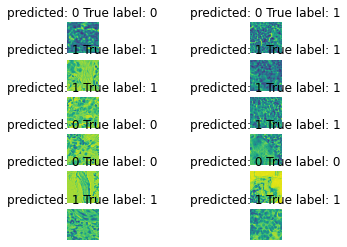

In [ ]:
visualize_model(model_resnet,test_loader,num_images=12)

In [ ]:
#save model
torch.save(model_resnet.state_dict(), 'model_resnet')



> VGG

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
cudnn.benchmark = True
model_vgg16 = models.vgg16(pretrained=True)#choosing the model

num_features = model_vgg16.classifier[6].in_features
features = list(model_vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 2)]) # Add our layer with 4 outputs
model_vgg16.classifier = nn.Sequential(*features)
model_vgg16 = model_vgg16.to(device)#To train on GPU
criterion = nn.CrossEntropyLoss()#Defined cross entropy loss

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)#choose which parameters to optimize and hyperparameters

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_vgg16 = train_model(model_vgg16, criterion, optimizer_ft, exp_lr_scheduler,train_loader, test_loader,num_epochs=5)

Epoch 0/4
----------
train Loss: 4.5745 Acc: 0.9603
train Sensitivity is 0.9647739662836534

train specificity is 0.9571877633766884

train precision is 0.9386526095897118

Confusion matrix [[84043  3759]
 [ 2100 57515]]
val Loss: 4.2392 Acc: 0.9507
val Sensitivity is 0.9544776625313538

val specificity is 0.9480350763234816

 val precision is 0.9263133655712359


Confusion matrix [[40866  2240]
 [ 1343 28159]]

Epoch 1/4
----------
train Loss: 3.6212 Acc: 0.9647
train Sensitivity is 0.9805753585507003

train specificity is 0.9539532129108677

train precision is 0.935312

Confusion matrix [[83759  4043]
 [ 1158 58457]]
val Loss: 4.3155 Acc: 0.9504
val Sensitivity is 0.9667819130906379

val specificity is 0.9392427968264279

 val precision is 0.9158986545069201


Confusion matrix [[40487  2619]
 [  980 28522]]

Epoch 2/4
----------
train Loss: 2.9182 Acc: 0.9777
train Sensitivity is 0.9753753250020968

train specificity is 0.9792601535272545

train precision is 0.9696338046958378

Confu

In [ ]:
visualize_model(model_vgg16,test_loader,num_images=6)

NameError: ignored

In [ ]:
input = torch.randn(1, 3, 96, 96)
out = net(input)
print(out)

histopathologic-cancer-detection.zip  sample_submission.csv  train_labels.csv
model_resnet			      test
sample_data			      train
